In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

n = 10
c = 3e8
T_tx = 10  # da regolare
r_max = 60e9  # Marte

In [2]:
### Generates a random network of n nodes (the first one corresponds to earth)
### r = max distance

def generate_network(n,r_max,seed=100,polar = False):
    
    np.random.seed(seed)
    nodes = np.zeros((n,3))
    
    r = np.random.rand(n,1)*r_max
    r[0] = 0 #Earth
    theta = np.random.rand(n,1)*4*np.pi - 2*np.pi
    phi = np.random.rand(n,1)*4*np.pi - 2*np.pi
    
    if polar==True:
        return np.hstack((r,theta,phi))  #polar coordinates
    
    x = r * np.cos(theta) * np.sin(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(phi)
    
    return np.hstack((x,y,z))   #cartesian coordinates

In [3]:
### Creates the weighted adjacency matrix of the network
### Entries represent propagation times between nodes

def adjacency_matrix(nodes):
    A = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            A[i,j] = A[j,i] = np.linalg.norm(nodes[i,:]-nodes[j,:]) / c
    return A

In [4]:
nodes = generate_network(n,r_max,polar=True)
A = adjacency_matrix(nodes)

#test
print(nodes.shape)
print(A.shape)

(10, 3)
(10, 10)


In [5]:
def plot_network(nodes):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(nodes[1:,0],nodes[1:,1],nodes[1:,2])
    ax.scatter(nodes[0,0],nodes[0,1],nodes[0,2],color="red",s=100)   #Earth
    plt.show()

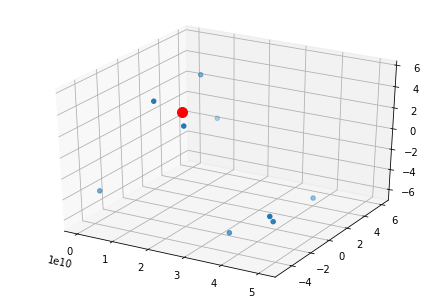

In [6]:
plot_network(nodes)

In [7]:
def add_temporal_dim(A,n_updates):
    At = np.broadcast_to(A.reshape((n,n,1)),(n,n,n_updates))
    ### At = ???(At) ##rimuovere link disattivati
    return At

In [8]:
At = add_temporal_dim(A,40)

#test
print(At.shape)

(10, 10, 40)
